# Assessmet of key metrics in 1/10th degree MOM6 experiments: Time series

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
from datetime import timedelta
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter
import matplotlib.ticker as mticker

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34867/status,
Dashboard: /proxy/34867/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35837,Workers: 8
Dashboard: /proxy/34867/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:37145,Total threads: 6
Dashboard: /proxy/41567/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:37339,


In [4]:
session = cc.database.create_session()
path_output_SWMT = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'

In [5]:
exptdict = OrderedDict([
    ('pa_z_v13', # 1/10th panantarctic zstar run with ACCESS-OM2-01 year 200 IC + BF
     {'expt': 'panant-01-zstar-v13'}),
    ('pa_h_v13', # 1/10th panantarctic hybrid run with ACCESS-OM2-01 year 200 IC + BF
     {'expt': 'panant-01-hycom1-v13'}),
    ('pa_z_yr2', # 1/10th panantarctic zstar run with ACCESS-OM2-01 year 2 IC + BF
     {'expt': 'panant-01-zstar-ACCESSyr2'}),
    ('gl_z_v1', # 1/10th global zstar run (version 1) with ACCESS-OM2-01 year 200 IC
     {'expt': 'global-01-v1'}),
    ('gl_z_v2', # 1/10th global zstar run (version 2) with ACCESS-OM2-01 year 2 IC
     {'expt': 'global-01-v2'}),
    ('gl_h_v3', # 1/10th global hybrid run (version 3) with ACCESS-OM2-01 year 2 IC
     {'expt': 'global-01-v3'})
])

In [6]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'ind_iso_min': [3647, 5151, 581, 1141],
    'ind_iso_max': [4307, 134, 960, 1830]}

## Load data

In [7]:
%%time
ekeys = ['pa_z_v13', 'pa_h_v13', 'pa_z_yr2', 'gl_z_v1', 'gl_z_v2', 'gl_h_v3']
for ekey in ekeys:
    e = exptdict[ekey]
    
    # Kinetic Energy
    e['KE'] = cc.querying.getvar(
        e['expt'], 'KE', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    e['KE']['Time'] = e['KE'].Time/365 + 1
    e['KE'] = e['KE'].sum('Layer')
    
    # Global Heat
    e['Heat'] = cc.querying.getvar(
        e['expt'], 'Heat', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    e['Heat']['Time'] = e['Heat'].Time/365 + 1
    
    # Global Salt
    e['Salt'] = cc.querying.getvar(
        e['expt'], 'Salt', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    e['Salt']['Time'] = e['Salt'].Time/365 + 1
    
    # CFL criteria
    e['CFL'] = cc.querying.getvar(
        e['expt'], 'max_CFL_trans', session, ncfile='ocean.stats.nc',
        decode_times=False, chunks={'Time': '200 MB'})
    e['CFL']['Time'] = e['CFL'].Time/365 + 1
    
    # Sea ice extent
    area = cc.querying.getvar(
        e['expt'], 'areacello', session, n=1,
        chunks={'xh': '200 MB', 'yh': '200 MB'})
    siconc = cc.querying.getvar(
        e['expt'], 'siconc', session, frequency='1 monthly',
        chunks={'xT': '200 MB', 'yT': '200 MB'}).rename({'yT':'yh', 'xT':'xh'})
    e['siext'] = (siconc*area).sum(['xh', 'yh']).compute()
    
    # Drake Passage trasnport
    umo_2d = cc.querying.getvar(
        e['expt'], 'umo_2d', session, frequency='1 monthly',
        chunks={'xq': '200 MB', 'yh': '200 MB'})
    e['DP'] = umo_2d.sel(xq=-71,method='nearest').sel(yh=slice(-82,-50)).sum(
        'yh').compute()/1e9
    
    # Transport stream function
    psi = cc.querying.getvar(
        e['expt'], 'vmo', session, frequency='1 monthly',
        chunks={'xh': '200MB', 'yq': '200MB'}).sum('xh')
    e['psi'] = (psi.cumsum('rho2_l')-psi.sum('rho2_l'))/1e9
    
    # SWMT in four DSW formation regions
    ds_SWMT = xr.open_mfdataset(
        path_output_SWMT + 'SWMT_in_DSW_region_' + e['expt']  + '*.nc')
    e['swmt'] = (
        ds_SWMT.binned_salt_transformation_in_DSW_region +
        ds_SWMT.binned_heat_transformation_in_DSW_region).compute()
    
    # volume transport across 1000-m isobath
    ds_transp1000m = xr.open_mfdataset(
        path_output_SWMT + 'vol_transp_across_contour_' + e['expt'] + '*.nc')
    transp1000m = ds_transp1000m.vol_trans_across_contour.assign_coords(
        {'lon': ds_transp1000m.lon[0, :].drop('time'),
         'lat': ds_transp1000m.lat[0, :].drop('time')})
    # Sum over all density bins above a certain density and calculate the
    # cumulative sum along the isobaths. Take yearly mean".
    e['transp1000m_37_17'] = transp1000m.sel(
        rho2_l=slice(1037.17, None)).sum('rho2_l').cumsum(
        'contour_index').groupby('time.year').mean()
    e['transp1000m_37_1'] = transp1000m.sel(
        rho2_l=slice(1037.1, None)).sum('rho2_l').cumsum(
        'contour_index').groupby('time.year').mean()
    
    # computed in cell below
    ds_TS = xr.open_dataset(
        path_output_SWMT + 'Abyssal_temp_salinity_' + e['expt'] + '.nc')
    e['T_abyss'] = ds_TS.thetao
    e['S_abyss'] = ds_TS.so
    
    # shelf properties
    ds_shelf = xr.open_mfdataset(
        path_output_SWMT + 'Timeseries_shelf_properties_daily_' +
        e['expt'] + '*.nc')
    ds_shelf_m = xr.open_mfdataset(
        path_output_SWMT + 'Timeseries_shelf_properties_monthly_' +
        e['expt'] + '*.nc')
    if ekey == 'gl_z_v1':
        ds_shelf = ds_shelf.sel(time=slice(None, "2021"))
        ds_shelf_m = ds_shelf_m.sel(time=slice(None, "2021"))
    elif ekey == 'gl_z_v2':
        ds_shelf = ds_shelf.sel(time=slice("1993", None))
        ds_shelf_m = ds_shelf_m.sel(time=slice("1993", None))
    elif ekey == 'gl_h_v3':
        ds_shelf = ds_shelf.sel(time=slice(None, "2019"))
        ds_shelf_m = ds_shelf_m.sel(time=slice(None, "2019"))
    e['SST_shelf'] = ds_shelf.tos
    e['T_bot_shelf'] = ds_shelf.tob
    e['SSS_shelf'] = ds_shelf.sos
    e['S_bot_shelf'] = ds_shelf.sob
    e['MLD_shelf'] = ds_shelf.mlotst
    e['ice_conc_shelf'] = ds_shelf.siconc
    e['ice_thick_shelf'] = ds_shelf.sithick
    
    e['rho2_surf_shelf'] = ds_shelf_m.rhopot2_surface
    e['rho2_bot_shelf'] = ds_shelf_m.rhopot2_bottom

CPU times: user 57.7 s, sys: 5.38 s, total: 1min 3s
Wall time: 1min 59s


## Plots

In [8]:
c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

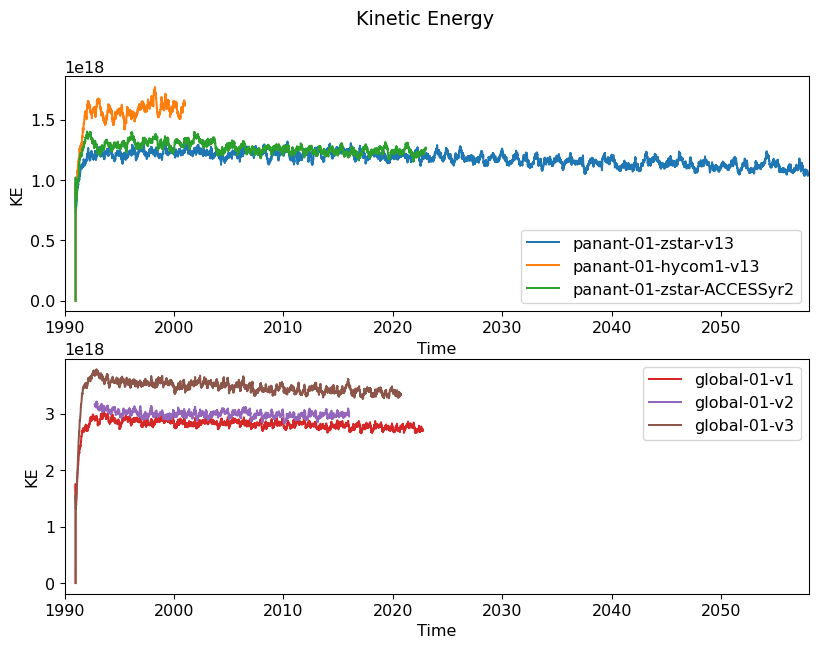

In [9]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['KE'].plot(label=e['expt'])
plt.legend()
plt.xlim(1990, 2058)


plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys[3:]):
    e = exptdict[ekey]
    e['KE'].plot(label=e['expt'], color=c[i+3])
plt.legend()
plt.xlim(1990, 2058)

plt.suptitle('Kinetic Energy')
plt.show()

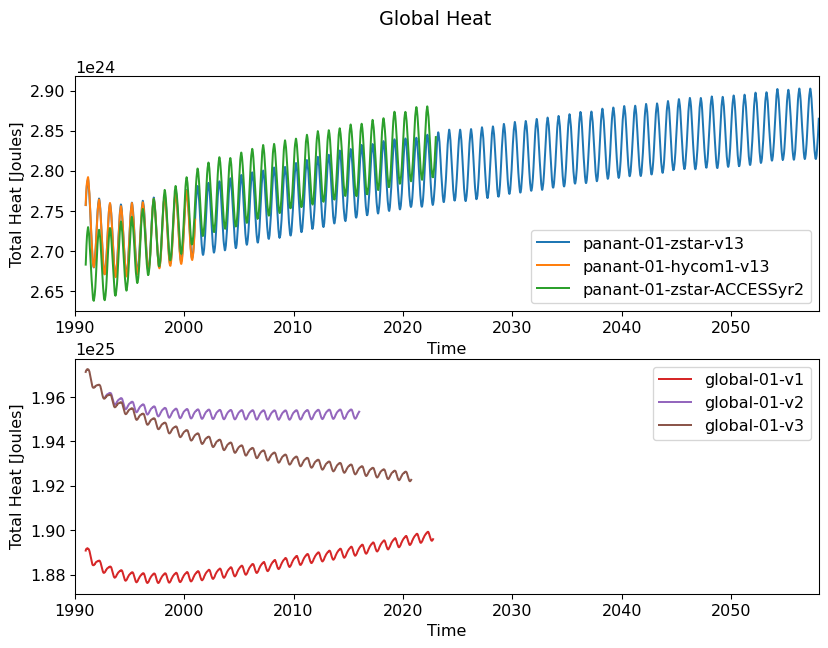

In [10]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['Heat'].plot(label=e['expt'])
plt.legend()
plt.xlim(1990, 2058)

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys[3:]):
    e = exptdict[ekey]
    e['Heat'].plot(label=e['expt'], color=c[i+3])
plt.legend()
plt.xlim(1990, 2058)

plt.suptitle('Global Heat')
plt.show()

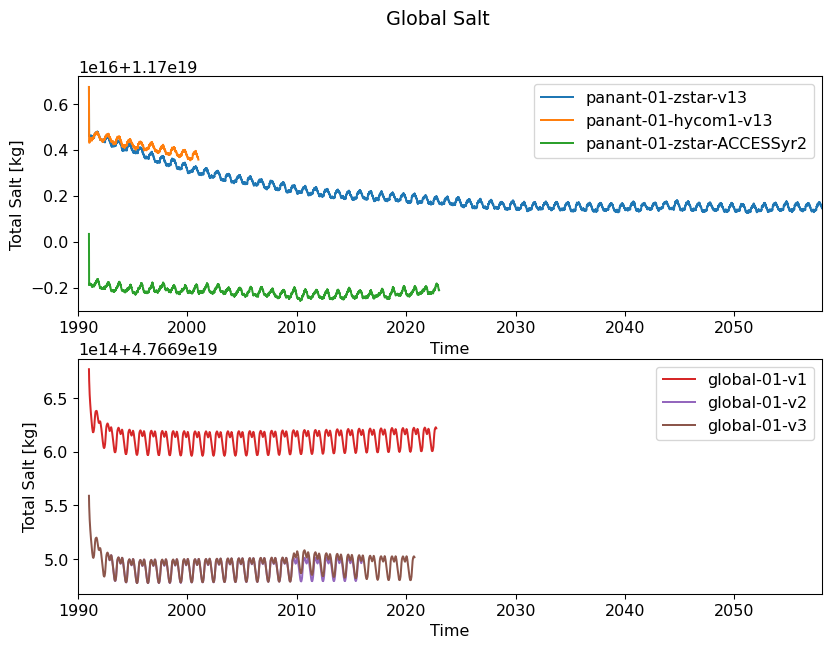

In [11]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['Salt'].plot(label=e['expt'])
plt.legend()
plt.xlim(1990, 2058)

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys[3:]):
    e = exptdict[ekey]
    e['Salt'].plot(label=e['expt'], color=c[i+3])
plt.legend()
plt.xlim(1990, 2058)

plt.suptitle('Global Salt')
plt.show()

#### CFL criteria should be below 0.5 to prevent trunctation of the velocity

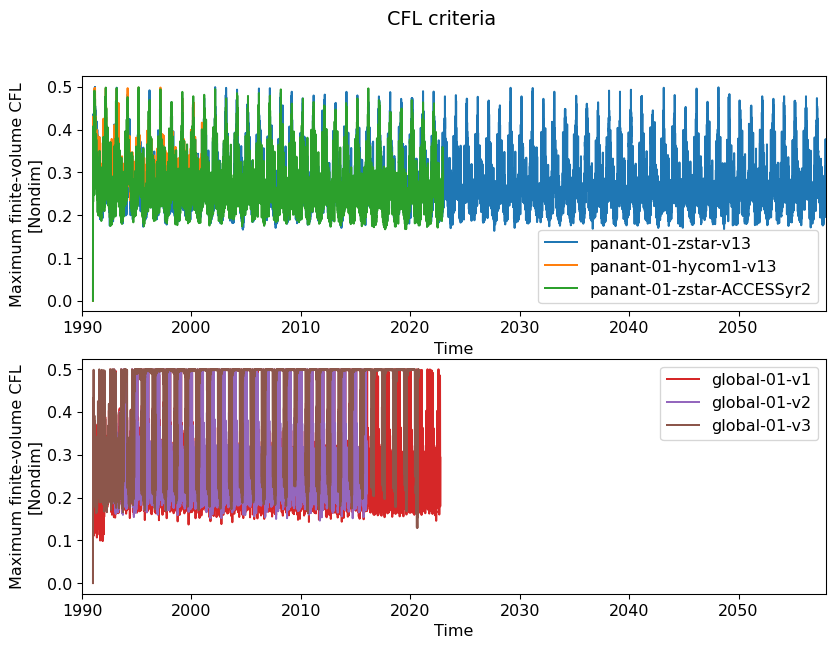

In [12]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys[:3]):
    e = exptdict[ekey]
    e['CFL'].plot(label=e['expt'])
plt.legend()
plt.xlim(1990, 2058)

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys[3:]):
    e = exptdict[ekey]
    e['CFL'].plot(label=e['expt'], color=c[i+3])
plt.legend()
plt.xlim(1990, 2058)

plt.suptitle('CFL criteria')
plt.show()

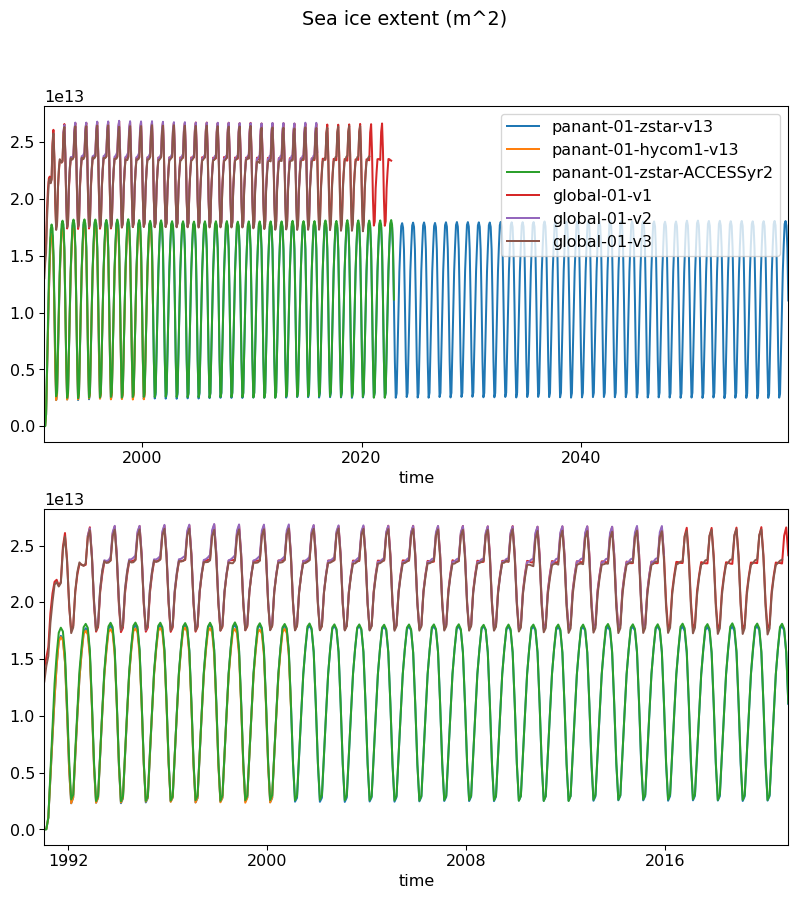

In [13]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['siext'].plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.legend()

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['siext'].sel(time=slice(None, '2020')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.suptitle(r'Sea ice extent (m^2)')
plt.show()

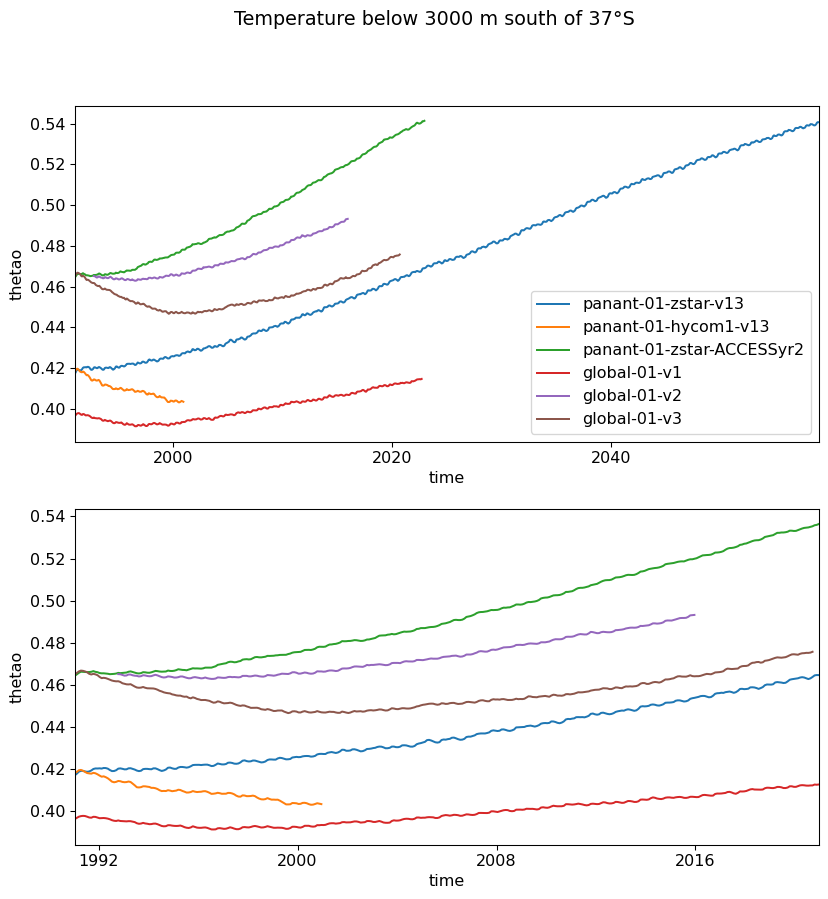

In [14]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['T_abyss'].plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.legend()

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['T_abyss'].sel(time=slice(None, '2020')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.suptitle('Temperature below 3000 m south of 37°S')
plt.show()

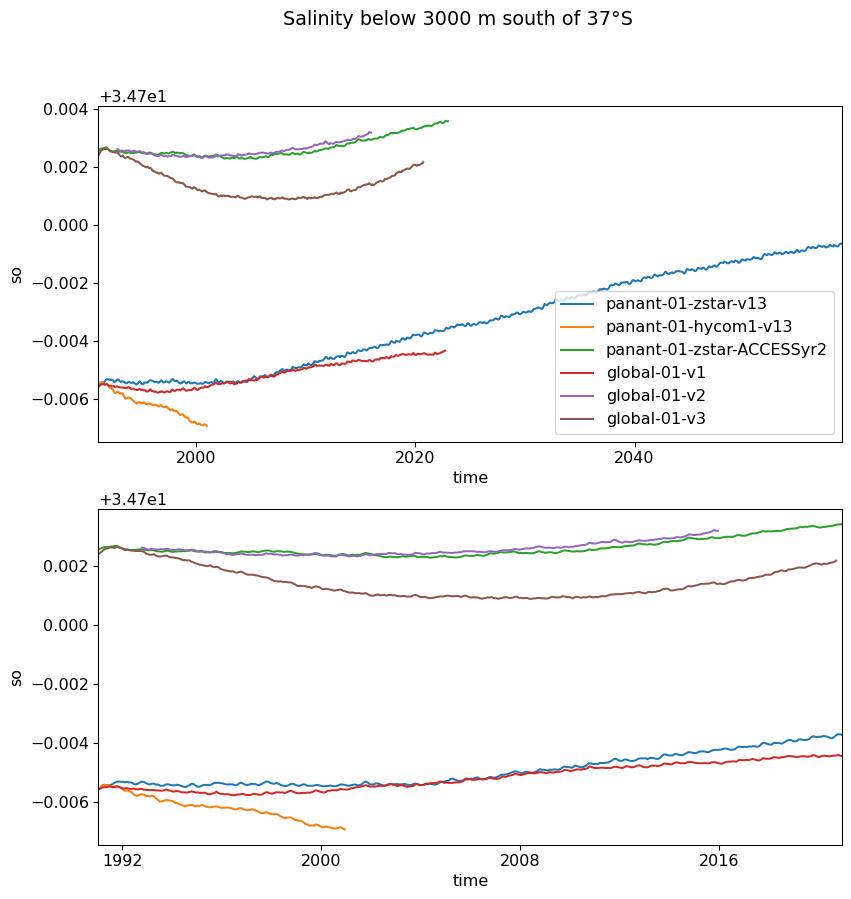

In [15]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['S_abyss'].plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['S_abyss'].sel(time=slice(None, '2020')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.suptitle('Salinity below 3000 m south of 37°S')
plt.show()

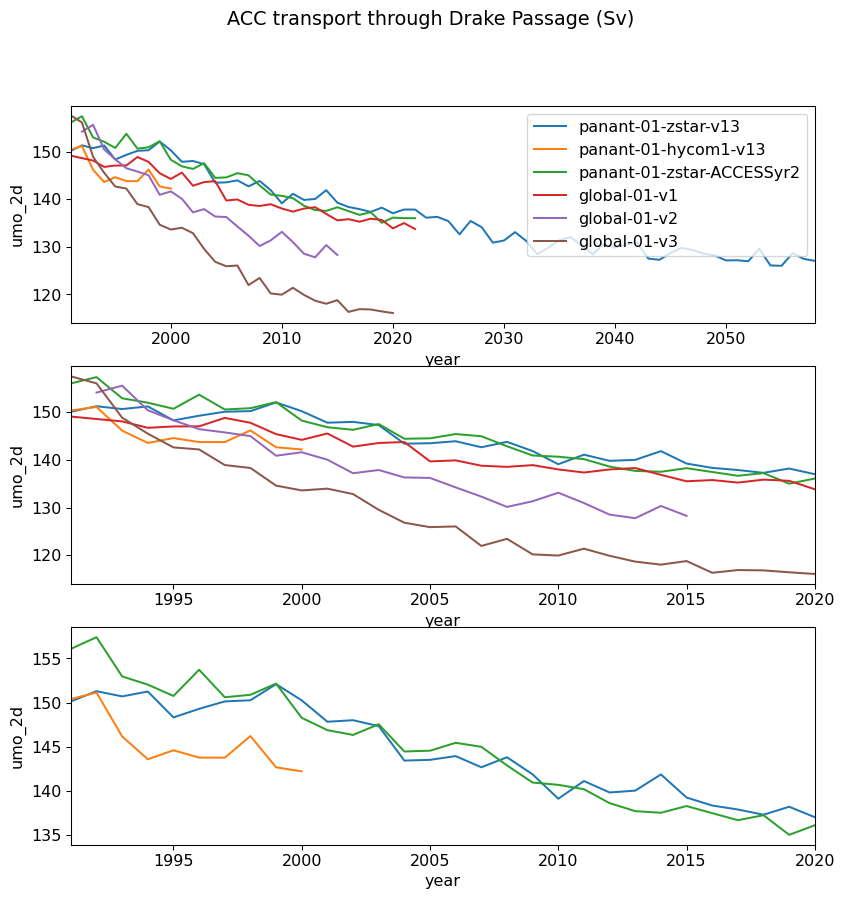

In [16]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['DP'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['DP'].sel(time=slice(None, '2020')).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(['pa_z_v13', 'pa_h_v13', 'pa_z_yr2']):
    e = exptdict[ekey]
    e['DP'].sel(time=slice(None, '2020')).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.suptitle('ACC transport through Drake Passage (Sv)')
plt.show()

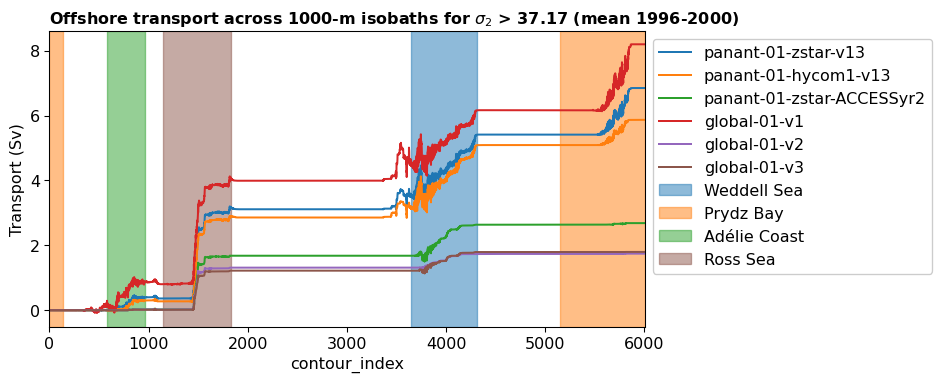

In [19]:
fig = plt.figure(figsize=(8, 4))
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['transp1000m'].sel(year=slice(1996, 2000)).mean('year').plot(
        label=e['expt'])

col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']
for a, area_text in enumerate(DSW_region['name']):
    if area_text == 'Prydz':
        plt.axvspan(0, transp1000m.contour_index[DSW_region['ind_iso_max'][a]],
                    alpha=0.5, color=col[a], label=DSW_region['name_long'][a])
        plt.axvspan(transp1000m.contour_index[DSW_region['ind_iso_min'][a]], 6002,
                    alpha=0.5, color=col[a])
    else:
        plt.axvspan(transp1000m.contour_index[DSW_region['ind_iso_min'][a]],
            transp1000m.contour_index[DSW_region['ind_iso_max'][a]],
            alpha=0.5, color=col[a], label=DSW_region['name_long'][a])

plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(framealpha=1, loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('Transport (Sv)')
plt.title('Offshore transport across 1000-m isobaths for $\sigma_2$ > 37.17 (mean 1996-2000)',
          loc='left', fontweight='bold')
plt.show()

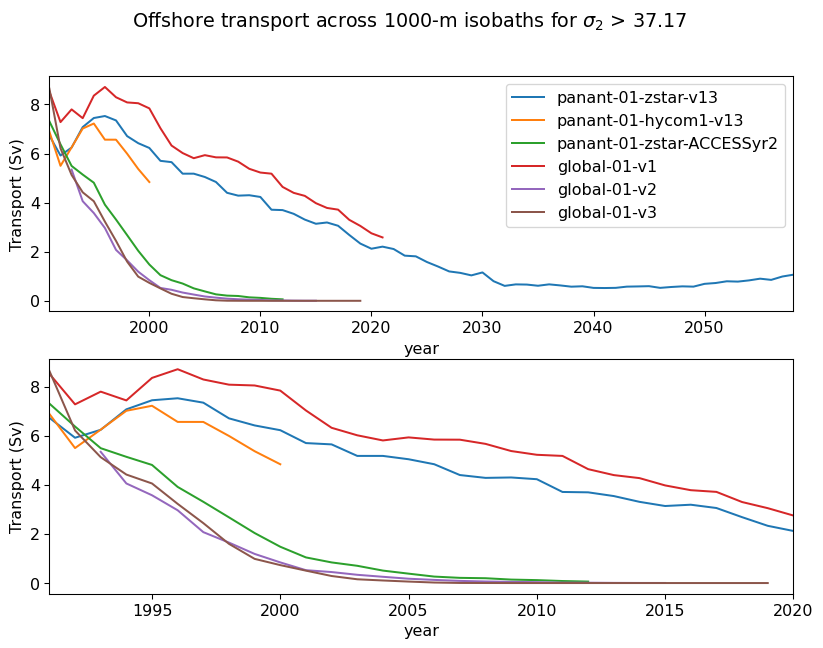

In [18]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['transp1000m'][:, -1].plot(label=e['expt'])
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.ylabel('Transport (Sv)')


plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['transp1000m'][:, -1].sel(year=slice(None, '2020')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.ylabel('Transport (Sv)')

plt.suptitle('Offshore transport across 1000-m isobaths for $\sigma_2$ > 37.17')
plt.show()

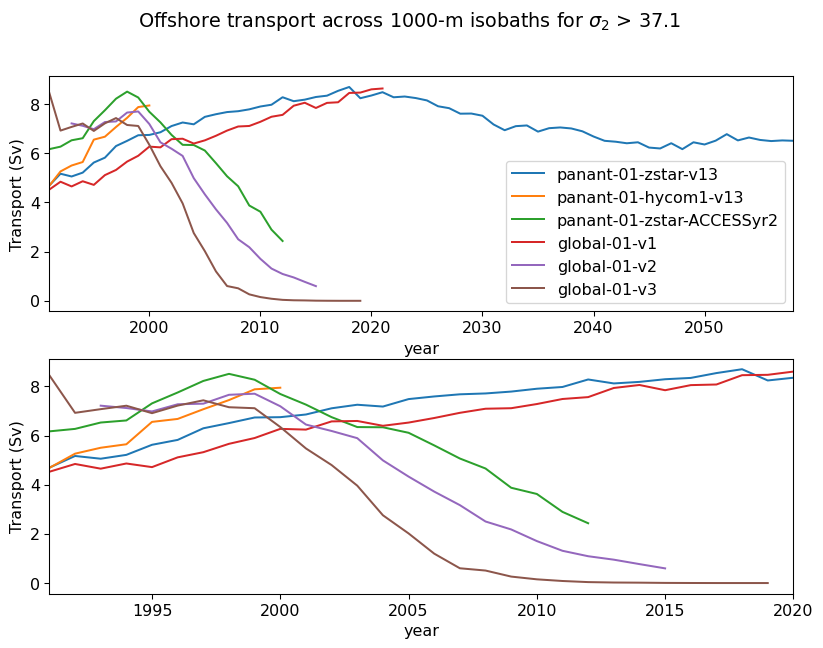

In [8]:
fig = plt.figure(figsize=(10, 7))

var = 'transp1000m_37_1'
var_sig = '37.1'

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e[var][:, -1].plot(label=e['expt'])
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.ylabel('Transport (Sv)')


plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e[var][:, -1].sel(year=slice(None, '2020')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.ylabel('Transport (Sv)')

plt.suptitle('Offshore transport across 1000-m isobaths for $\sigma_2$ > ' + var_sig)
plt.show()

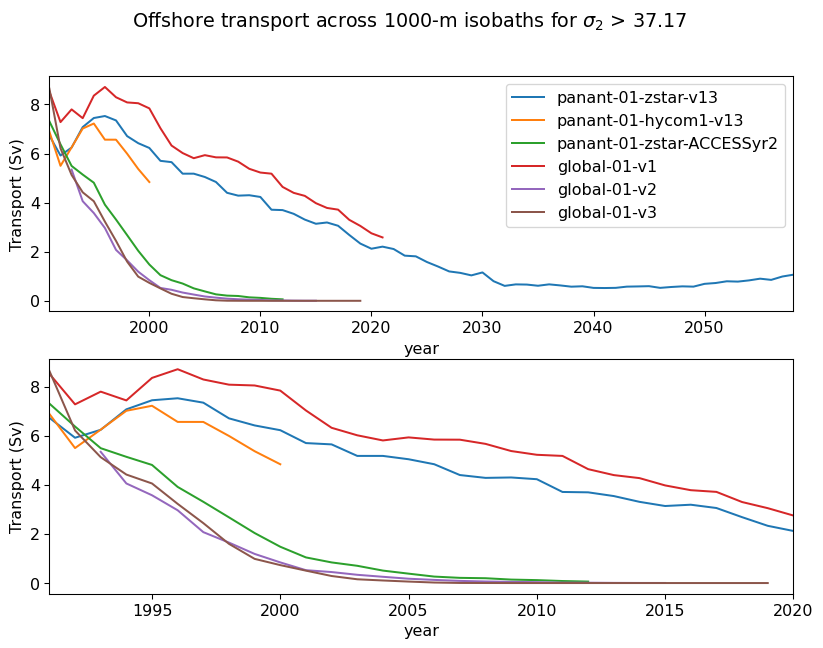

In [9]:
fig = plt.figure(figsize=(10, 7))

var = 'transp1000m_37_17'
var_sig = '37.17'

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e[var][:, -1].plot(label=e['expt'])
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.ylabel('Transport (Sv)')


plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e[var][:, -1].sel(year=slice(None, '2020')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.ylabel('Transport (Sv)')

plt.suptitle('Offshore transport across 1000-m isobaths for $\sigma_2$ > ' + var_sig)
plt.show()

In [17]:
%%time
lat = -60
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'] = e['psi'].sel(yq=lat, method='nearest').sel(rho2_l=slice(1036.5, None)).min(
        dim='rho2_l').compute()
    print(e['expt'] + ' done')

panant-01-zstar-v13 done
panant-01-hycom1-v13 done
panant-01-zstar-ACCESSyr2 done
global-01-v1 done
global-01-v2 done
global-01-v3 done
CPU times: user 4min 3s, sys: 37.1 s, total: 4min 40s
Wall time: 35min 7s


In [18]:
%%time
lat = -40
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'] = e['psi'].sel(yq=lat, method='nearest').sel(rho2_l=slice(1036.5, None)).min(
        dim='rho2_l').compute()
    print(e['expt'] + ' done')

panant-01-zstar-v13 done
panant-01-hycom1-v13 done
panant-01-zstar-ACCESSyr2 done
global-01-v1 done
global-01-v2 done
global-01-v3 done
CPU times: user 5min 1s, sys: 45.2 s, total: 5min 47s
Wall time: 44min 40s


In [14]:
%%time
lat = -40
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_upper_40S'] = e['psi'].sel(yq=lat, method='nearest').max(
        dim='rho2_l').compute()
    print(e['expt'] + ' done')

panant-01-zstar-v13 done
panant-01-hycom1-v13 done
panant-01-zstar-ACCESSyr2 done
global-01-v1 done
global-01-v2 done
global-01-v3 done
CPU times: user 7min 2s, sys: 39.7 s, total: 7min 42s
Wall time: 35min 2s


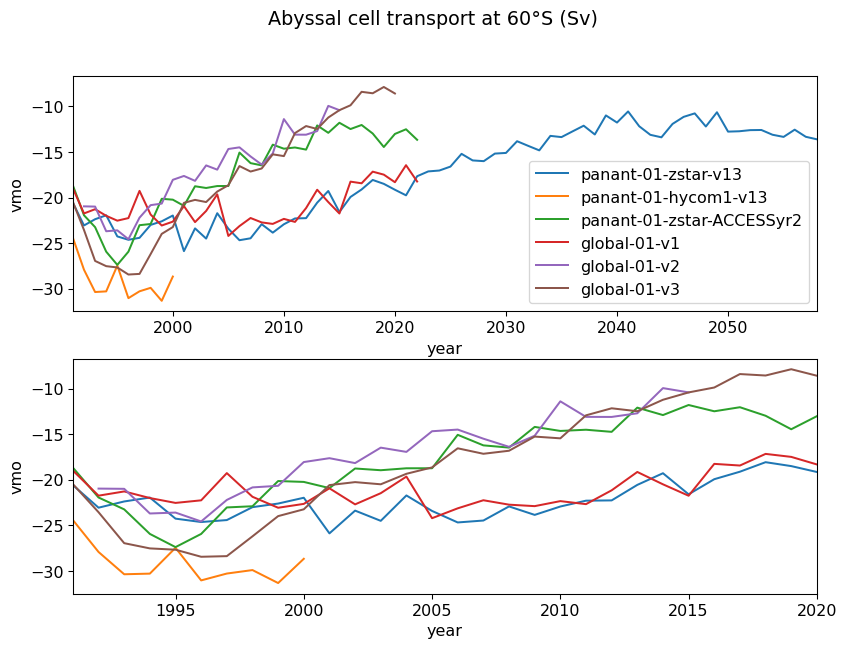

In [22]:
lat = -60

fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.legend()

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_60S'].sel(time=slice(None, '2020')).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.suptitle('Abyssal cell transport at ' + str(np.abs(lat)) + '°S (Sv)')
plt.show()

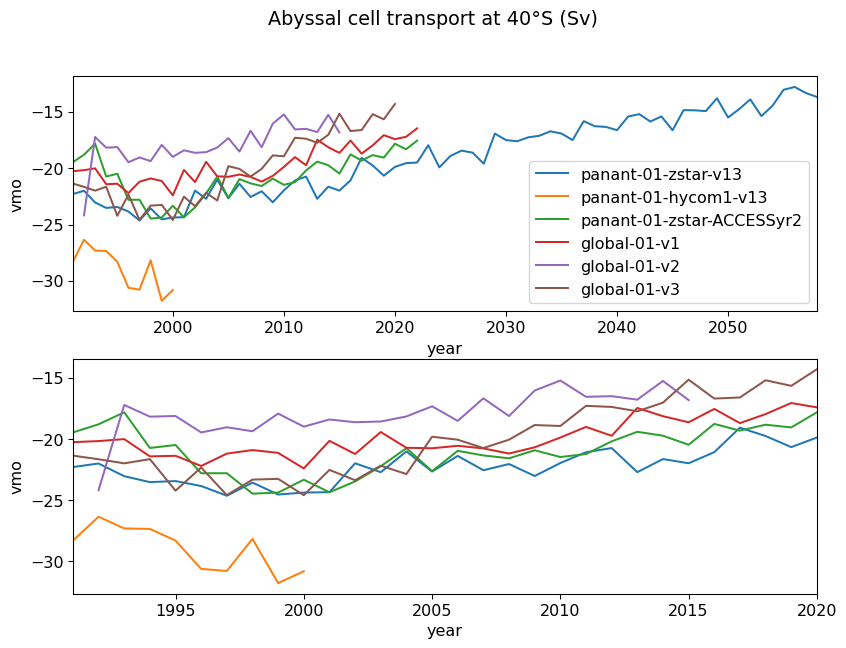

In [23]:
lat = -40

fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.legend()

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_40S'].sel(time=slice(None, '2020')).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.suptitle('Abyssal cell transport at ' + str(np.abs(lat)) + '°S (Sv)')
plt.show()

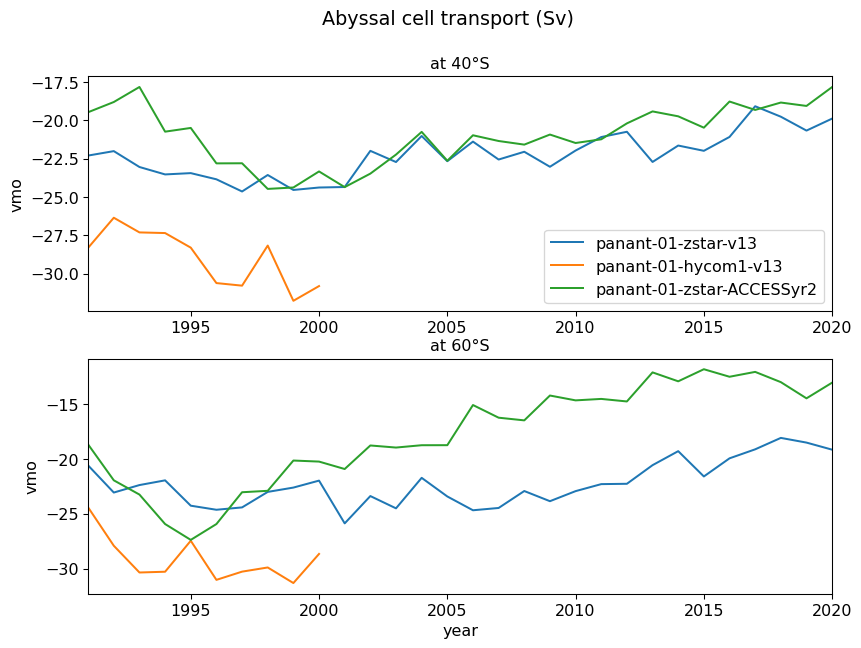

In [24]:
lat = -60

fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(['pa_z_v13', 'pa_h_v13', 'pa_z_yr2']):
    e = exptdict[ekey]
    e['psi_40S'].sel(time=slice(None, '2020')).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('at 40°S')
plt.xlabel('')
plt.legend()

plt.subplot(2, 1, 2)
for i, ekey in enumerate(['pa_z_v13', 'pa_h_v13', 'pa_z_yr2']):
    e = exptdict[ekey]
    e['psi_60S'].sel(time=slice(None, '2020')).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('at 60°S')

plt.suptitle('Abyssal cell transport (Sv)')
plt.show()

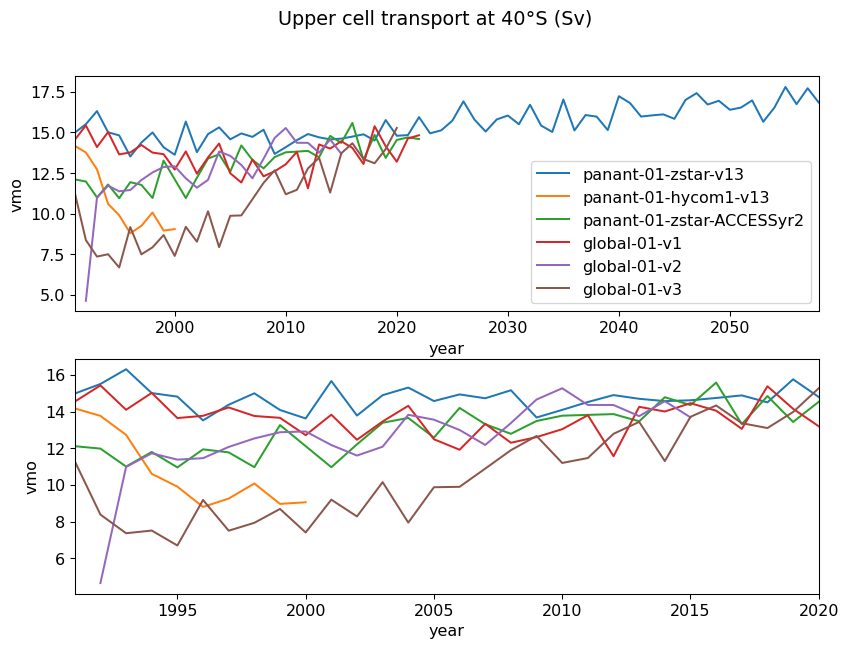

In [18]:
lat = -40

fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_upper_40S'].groupby('time.year').mean().plot(
        label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.legend()

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['psi_upper_40S'].sel(time=slice(None, '2020')).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.suptitle('Upper cell transport at ' + str(np.abs(lat)) + '°S (Sv)')
plt.show()

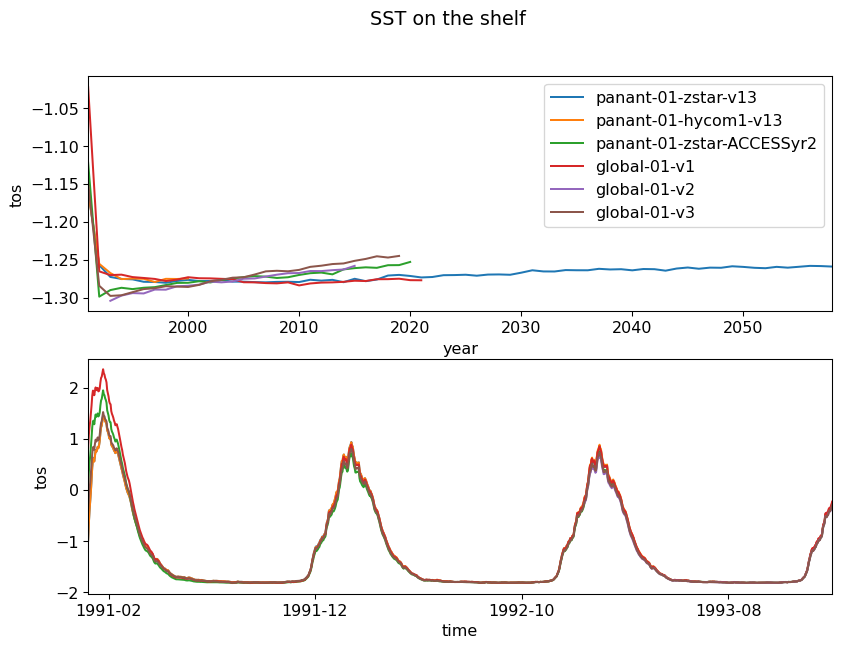

In [36]:
fig = plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['SST_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.legend()

plt.subplot(2, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['SST_shelf'].sel(time=slice(None, '1993')).plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')

plt.suptitle('SST on the shelf')
plt.show()

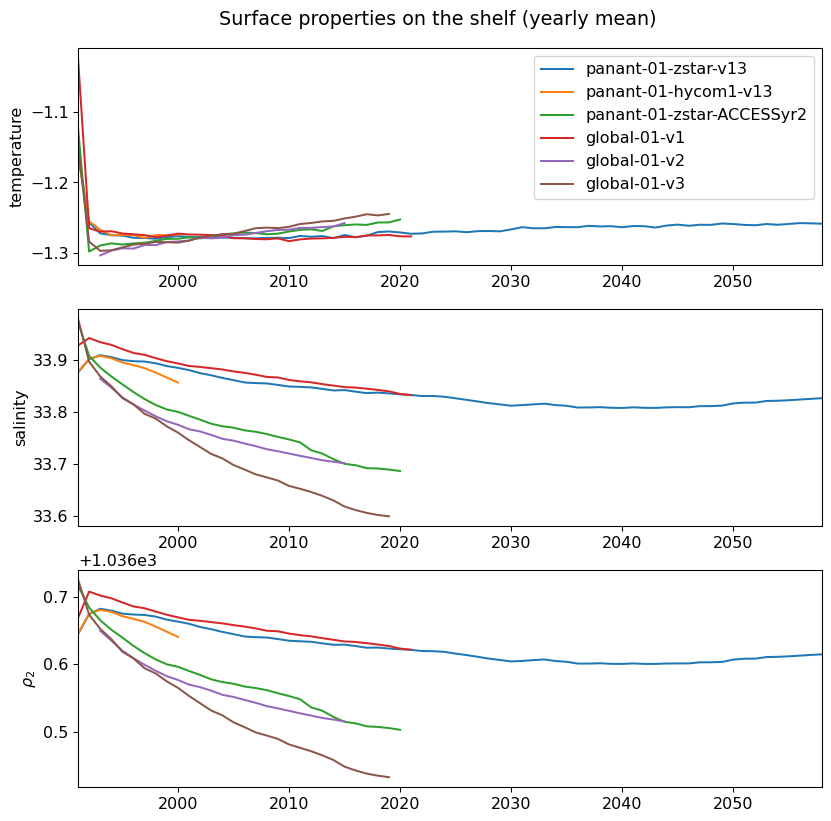

In [9]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['SST_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('temperature')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['SSS_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('salinity')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['rho2_surf_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel(r'$\rho_2$')

plt.suptitle('Surface properties on the shelf (yearly mean)', y=.92)
plt.show()

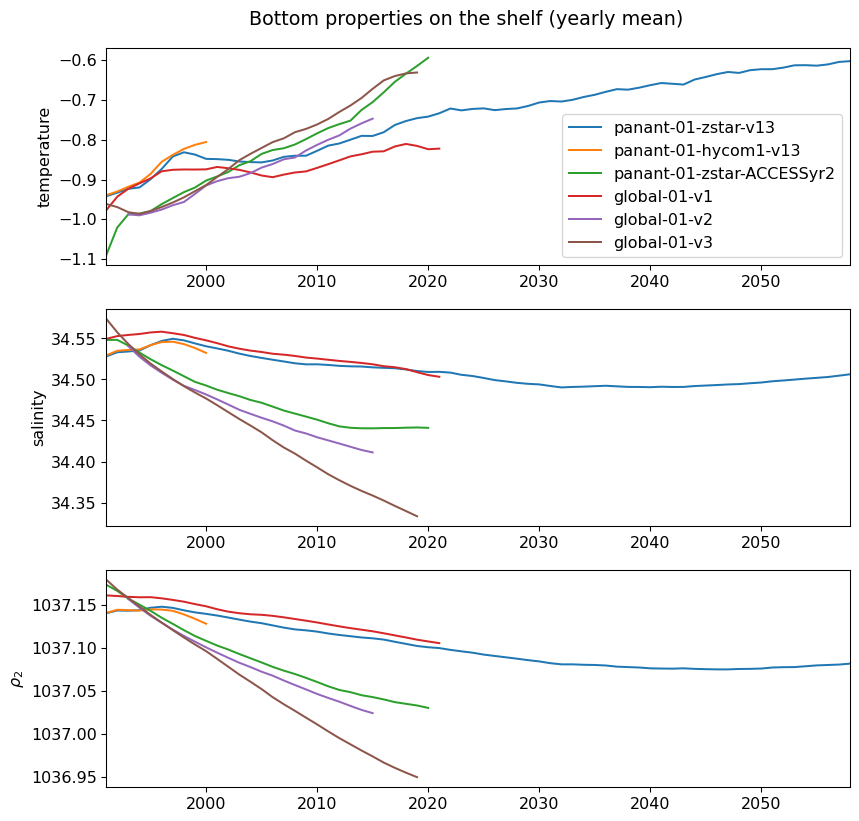

In [10]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['T_bot_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('temperature')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['S_bot_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('salinity')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['rho2_bot_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel(r'$\rho_2$')

plt.suptitle('Bottom properties on the shelf (yearly mean)', y=.92)
plt.show()

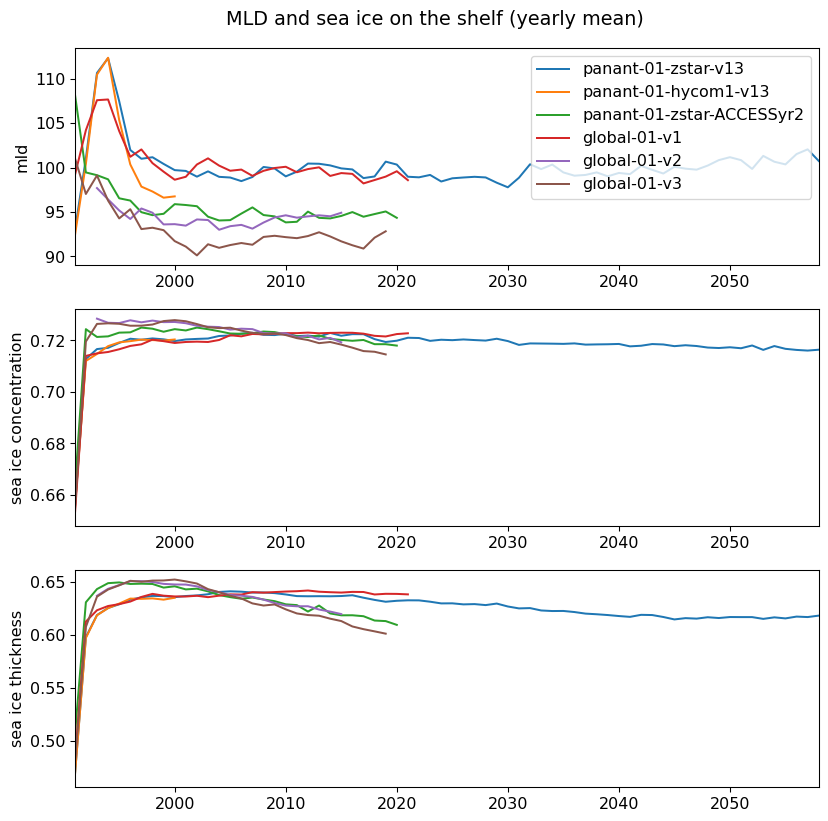

In [11]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['MLD_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('mld')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['ice_conc_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('sea ice concentration')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['ice_thick_shelf'].groupby('time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('sea ice thickness')

plt.suptitle('MLD and sea ice on the shelf (yearly mean)', y=.92)
plt.show()

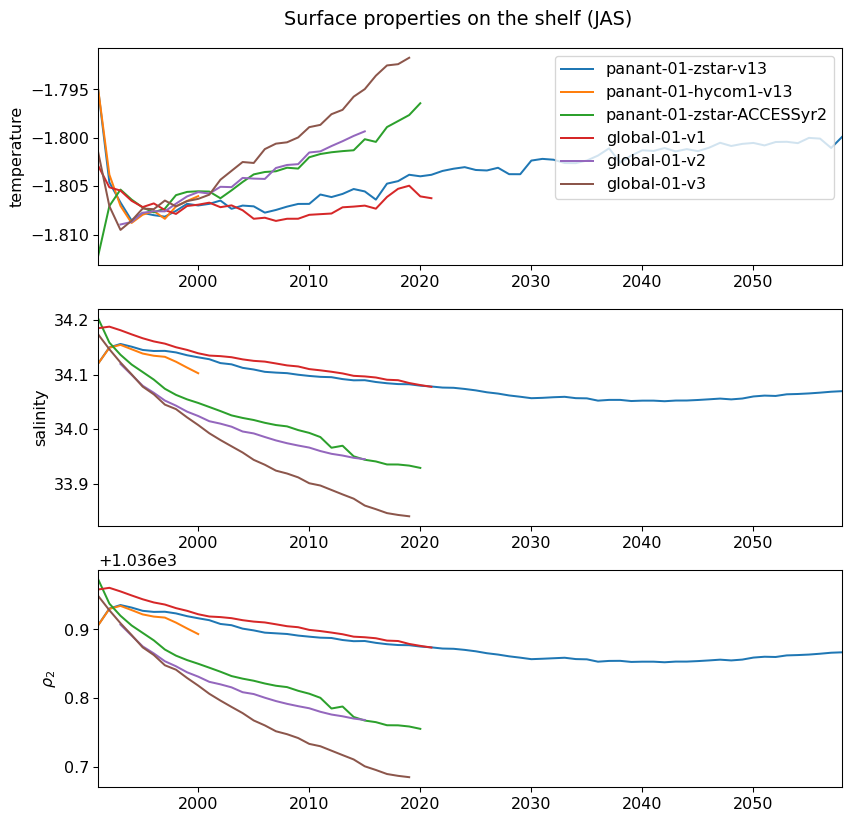

In [20]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['SST_shelf'].sel(
        time=e['SST_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('temperature')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['SSS_shelf'].sel(
        time=e['SSS_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('salinity')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['rho2_surf_shelf'].sel(
        time=e['rho2_surf_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel(r'$\rho_2$')

plt.suptitle('Surface properties on the shelf (JAS)', y=.92)
plt.show()

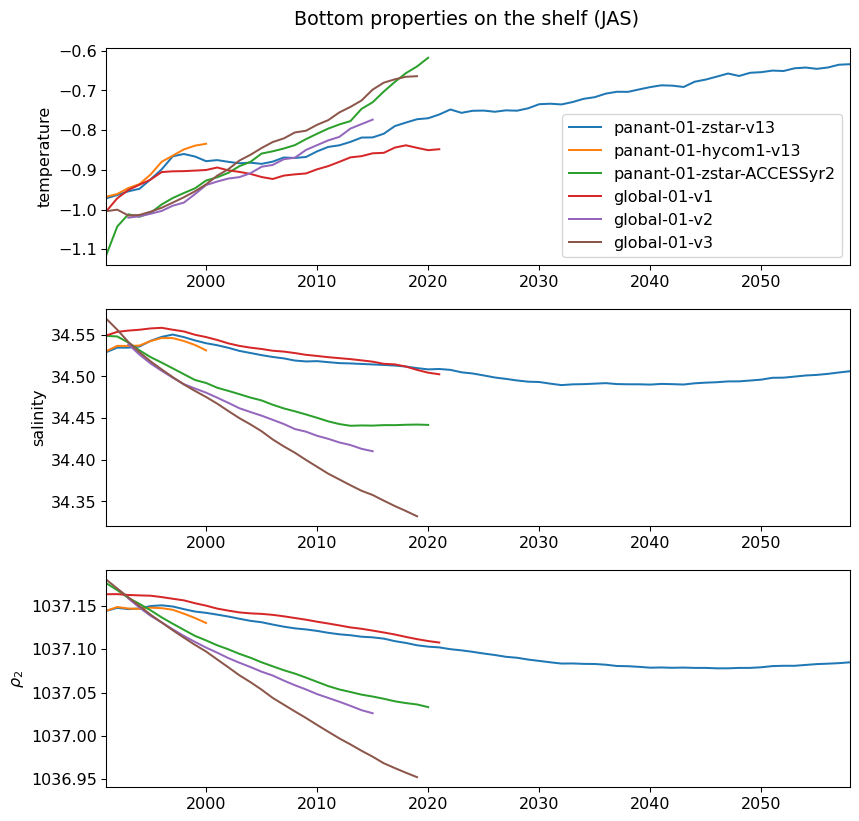

In [21]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['T_bot_shelf'].sel(
        time=e['T_bot_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('temperature')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['S_bot_shelf'].sel(
        time=e['S_bot_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('salinity')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['rho2_bot_shelf'].sel(
        time=e['rho2_bot_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel(r'$\rho_2$')

plt.suptitle('Bottom properties on the shelf (JAS)', y=.92)
plt.show()

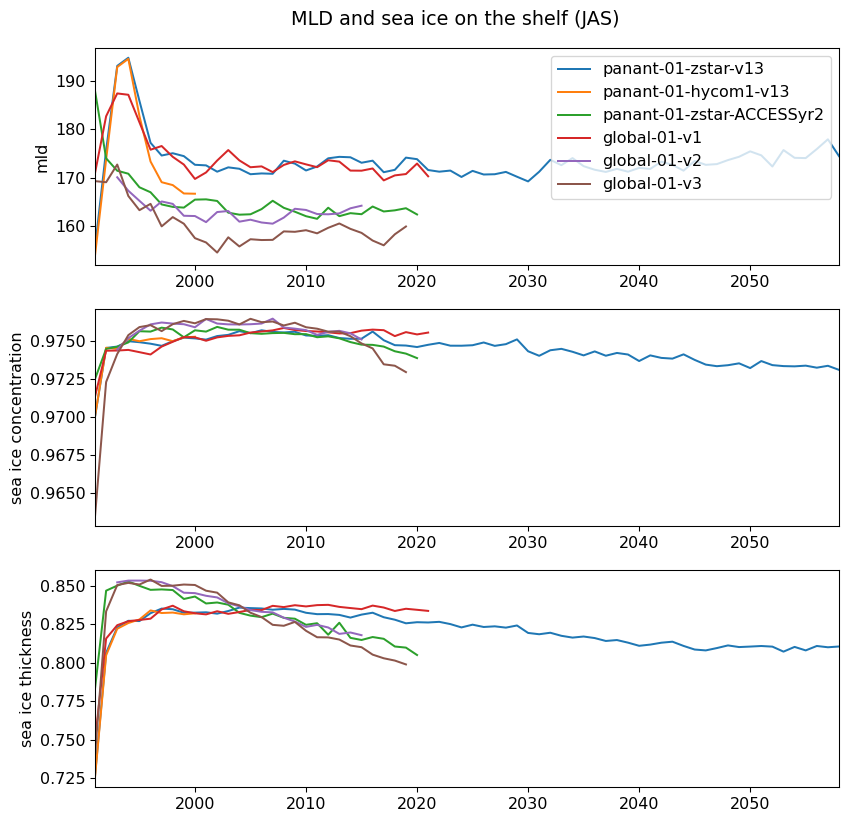

In [18]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['MLD_shelf'].sel(
        time=e['MLD_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('mld')
plt.legend()

plt.subplot(3, 1, 2)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['ice_conc_shelf'].sel(
        time=e['ice_conc_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('sea ice concentration')

plt.subplot(3, 1, 3)
for i, ekey in enumerate(ekeys):
    e = exptdict[ekey]
    e['ice_thick_shelf'].sel(
        time=e['ice_thick_shelf'].time.dt.month.isin([7, 8, 9])).groupby(
        'time.year').mean().plot(label=e['expt'])
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('')
plt.xlabel('')
plt.ylabel('sea ice thickness')

plt.suptitle('MLD and sea ice on the shelf (JAS)', y=.92)
plt.show()